In [1]:
import os, json

In [2]:
with open("AI4AM_topics3.json", "r+") as f:
    topics = json.load(f)

In [3]:
topics['Statistical Mechanics and Thermodynamics']['description']

'A branch of theoretical physics that uses statistical methods to explain the behavior of systems with a large number of particles, particularly at finite temperatures, and includes the study of thermodynamic potentials and phase behavior.'

In [4]:
list_topics = list()
for k,v in  topics.items():
    list_topics.append(f"{k} : {v['description']}")

list_topics[:2]

In [6]:
from langchain_community.embeddings import HuggingFaceEmbeddings

#### LOAD Fine tuning model

# Load the model from the checkpoint directory
model_name ='./results512a/checkpoint-1000'
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': False}
hf_fine_tuned = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)


No sentence-transformers model found with name ./results512a/checkpoint-1000. Creating a new one with MEAN pooling.
Some weights of BertModel were not initialized from the model checkpoint at ./results512a/checkpoint-1000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
dim_hf_model = len(hf_fine_tuned.embed_query("Statistical mechanics and thermodynamics"))

In [8]:
from langchain_openai import OpenAIEmbeddings

from utils import OPENAI_API_KEY


In [9]:
open_ai = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

In [10]:
len(open_ai.embed_query("Statistical mechanics and thermodynamics"))

1536

In [11]:
len(hf_fine_tuned.embed_documents(list_topics[:2] )), len(hf_fine_tuned.embed_documents(list_topics[:2] )[0]) # 2, 768

(2, 768)

### Get  embeddings for all topics

In [12]:
import numpy as np
def  embed_topics(topics, model):
    list_topics = list()
    for k,v in  topics.items():
        list_topics.append(f"{k} : {v['description']}")
    return np.array(model.embed_documents(list_topics))

emb_openai = embed_topics(topics, open_ai)
emb_hf = embed_topics(topics, hf_fine_tuned)
emb_hf.shape, emb_openai.shape

((121, 768), (121, 1536))

In [13]:
import matplotlib.pyplot as plt

def plot_weights(weight1, weight2, cl1, cl2):
    fig, ax = plt.subplots()
    #ax.bar(weight1, weight2, c=cl1, cmap='viridis')
    ax.scatter(weight1, weight2, c=cl2, cmap='viridis')
    ax.set_xlabel('weight1')
    ax.set_ylabel('weight2')
    plt.show()
    
def plot_weights(weight1, weight2, n_nodes, labels=['OpenAi', 'HuggingFace'], ):    
    
    # Set up the bar chart
    x = np.arange(len(weight1))  # Indices for the x-axis
    bar_width = 0.35  # Width of each bar

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 4))

    # Bar charts for each model
    bars1 = ax.bar(x - bar_width / 2, weight1, bar_width, label=labels[0])  # OpenAI
    bars2 = ax.bar(x + bar_width / 2, weight2, bar_width, label=labels[1])  # HuggingFace

    # Add labels and title
    ax.set_xlabel(f'Cluster Index {n_nodes}')
    ax.set_ylabel('Weight')
    ax.set_title('Comparison of Cluster Weights')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{i}' for i in x])
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


In [14]:
#from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,  GaussianMixture
from sklearn.cluster import KMeans


def _get_clusters(emb, 
                  n_nodes = 10, # estimated number nodes in a cluster
                  dim=None,  # reduced dimensionality of the embedding
                  clusters = 'gauss',# 'gauss' or 'kmeans', BayesianGaussianMixture or KMeans algoriths
                 ): 
    
    if not dim:
        if clusters == 'gauss':
            bgm = BayesianGaussianMixture(n_components=emb.shape[0]//n_nodes, 
                                      weight_concentration_prior_type='dirichlet_process').fit(emb)
            clusters =  bgm.predict(emb)
            return  clusters,  bgm, None
        elif clusters == 'kmeans':
            km = KMeans(n_clusters=emb.shape[0]//n_nodes).fit(emb)
            return  km.labels_,  km, None
        
    # Reduce dimentionality
    pca = PCA(n_components=dim)
    pca_results = pca.fit_transform(emb)
    #print( pca_results.shape)
            
    # Get clusters
    if clusters == 'gauss':
        bgm = BayesianGaussianMixture(n_components=emb.shape[0]//n_nodes, 
                                      weight_concentration_prior_type='dirichlet_process').fit(pca_results)
        clusters =  bgm.predict(pca_results)
        return  clusters,  bgm,  pca_results
    elif clusters == 'kmeans':
        km = KMeans(n_clusters=emb.shape[0]//n_nodes).fit(pca_results)
        return  km.labels_,  km,  pca_results

 n_nodes: 8


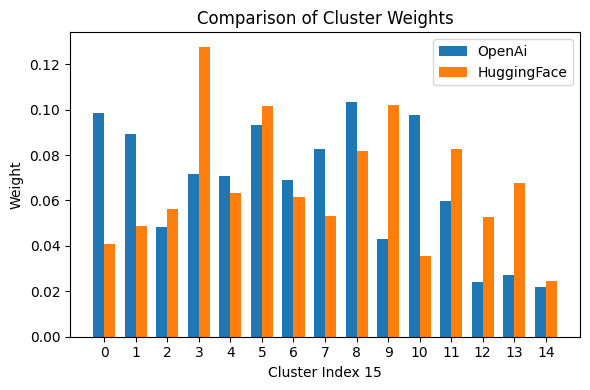

 n_nodes: 9


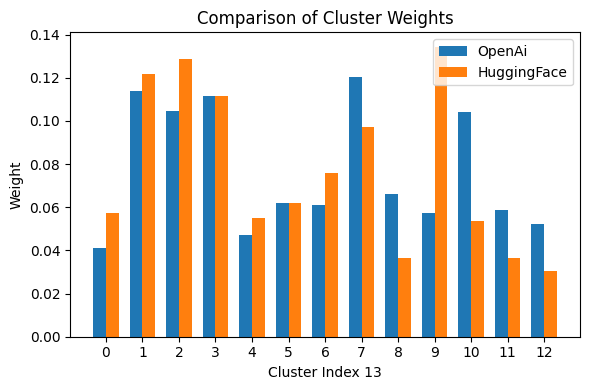

 n_nodes: 10


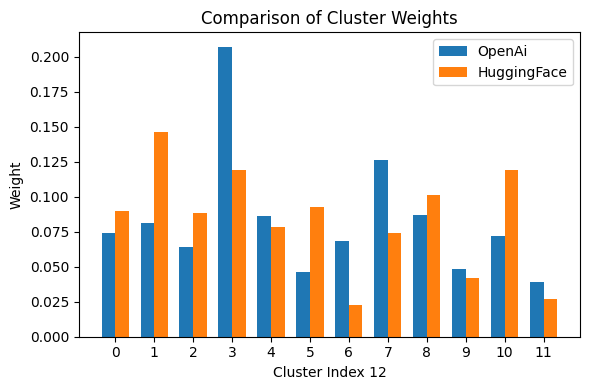

 n_nodes: 11


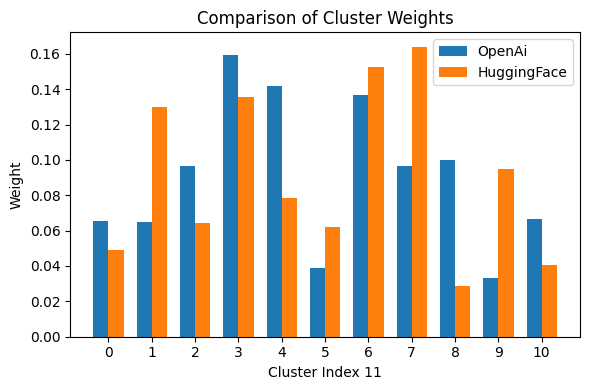

 n_nodes: 12


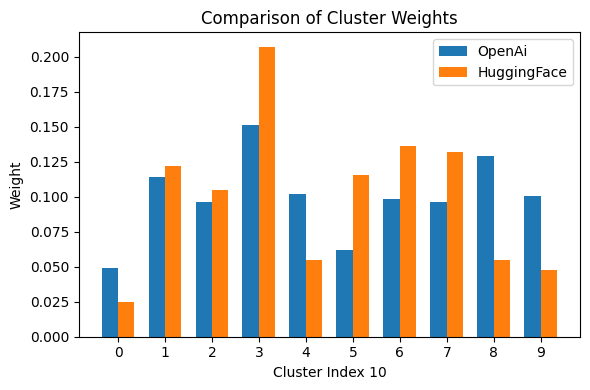

 n_nodes: 13


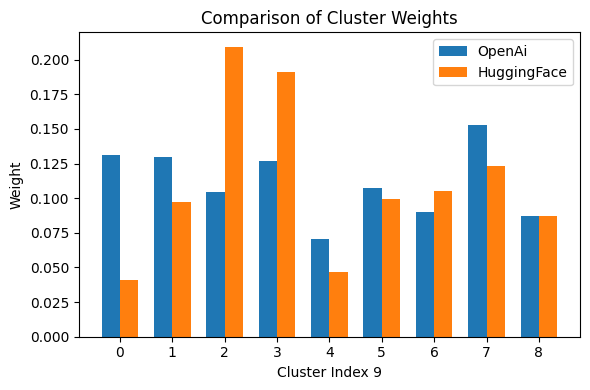

 n_nodes: 14


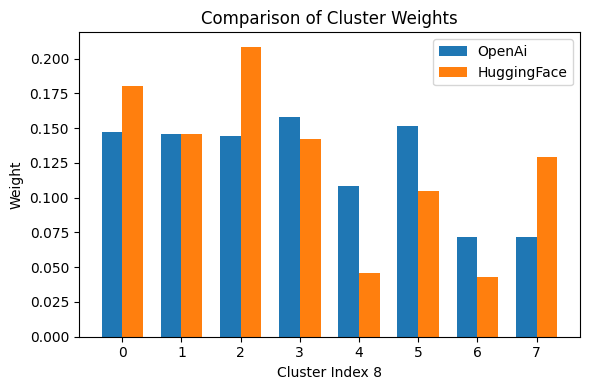

 n_nodes: 15


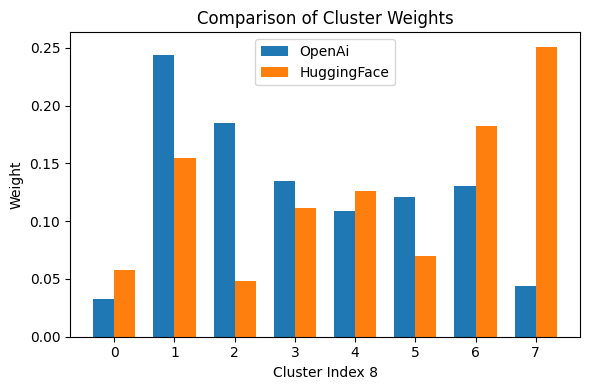

 n_nodes: 16


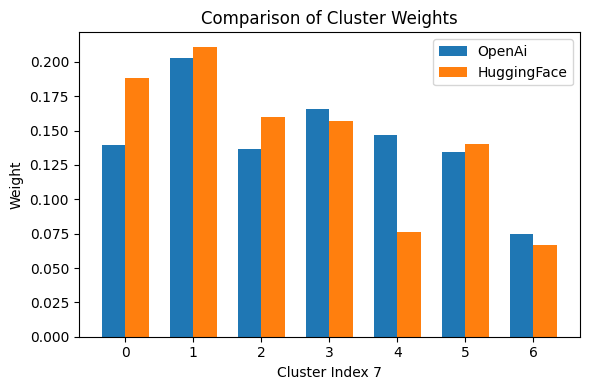

 n_nodes: 17


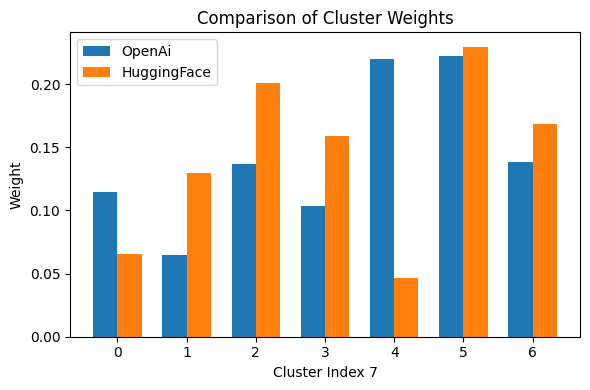

 n_nodes: 18


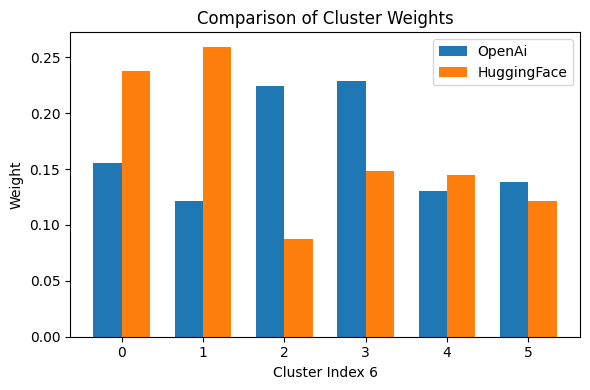

 n_nodes: 19


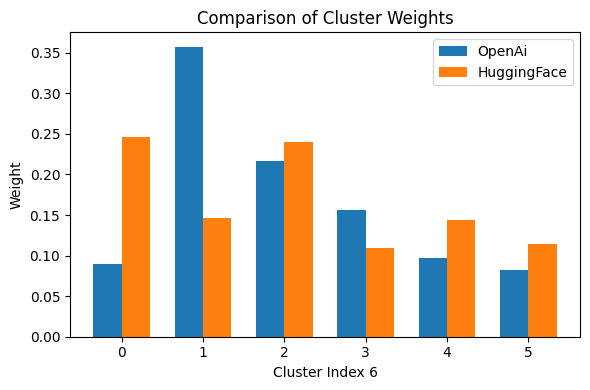

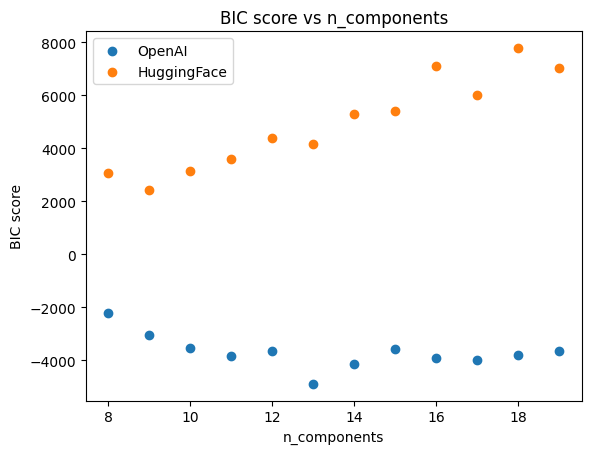

In [15]:
from sklearn.metrics import davies_bouldin_score,  silhouette_score

clusters = {"gauss_OpenAI": {}, "kmeans_OpenAI": {},  "gauss_HuggingFace": {}, "kmeans_HuggingFace": {}}
bic_scores = {'OpenAI': [], 'HuggingFace': []} # Bayesian Information Criterion
components = []

for  n_nodes in range(8,20,1):
    openai_cl, openai_bgm, pca_openai = _get_clusters(emb_openai, n_nodes= n_nodes, dim=20, clusters = 'gauss')
    clusters['gauss_OpenAI'][n_nodes] = {'model': openai_bgm, 'labels': openai_cl}
    hf_cl, hf_bgm, pca_hf = _get_clusters(emb_hf, n_nodes= n_nodes, dim=20, clusters = 'gauss')
    clusters['gauss_HuggingFace'][n_nodes] = {'model': hf_bgm, 'labels': hf_cl}
    print(f" n_nodes: {n_nodes}")
    n_components = emb_hf.shape[0]//n_nodes
    plot_weights(openai_bgm.weights_, hf_bgm.weights_,  n_components)
    
    #  BIC score
    pca_openai = pca_openai if  pca_openai is not None else emb_openai
    openai_gm = GaussianMixture(n_components=n_components).fit(pca_openai)
    bic_scores[ 'OpenAI'].append(openai_gm.bic(pca_openai))
    
    pca_hf = pca_hf if  pca_hf is not None else emb_hf
    hf_gm = GaussianMixture(n_components=n_components).fit(pca_hf)
    bic_scores[ 'HuggingFace'].append(hf_gm.bic(pca_hf))
                             
    components.append(n_nodes) # average nodes number in a cluster 
    
    
plt.scatter(components, bic_scores['OpenAI'], label = 'OpenAI')
plt.scatter(components, bic_scores['HuggingFace'], label = 'HuggingFace')
plt.legend()
plt.xlabel('n_components')
plt.ylabel('BIC score')
plt.title('BIC score vs n_components')
plt.show()
    

/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 n_nodes: 8


/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 n_nodes: 9


/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 n_nodes: 10


/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 n_nodes: 11


/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 n_nodes: 12


/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 n_nodes: 13


/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 n_nodes: 14


/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 n_nodes: 15


/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 n_nodes: 16


/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 n_nodes: 17


/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 n_nodes: 18


/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 n_nodes: 19


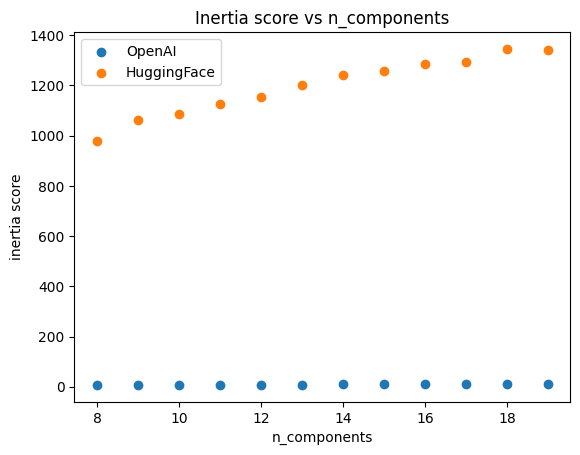

In [16]:
inertia_scores = {'OpenAI': [], 'HuggingFace': []} # Bayesian Information Criterion
components = []

for  n_nodes in range(8,20,1):
    openai_cl, openai_km, pca_openai = _get_clusters(emb_openai, n_nodes= n_nodes, dim=20, clusters = 'kmeans')
    clusters['kmeans_OpenAI'][n_nodes] = {'model': openai_km, 'labels': openai_cl}
    hf_cl, hf_km, pca_hf = _get_clusters(emb_hf, n_nodes= n_nodes, dim=20, clusters = 'kmeans')
    clusters['kmeans_HuggingFace'][n_nodes] = {'model': hf_km, 'labels': hf_cl}
    print(f" n_nodes: {n_nodes}")
    n_components = emb_hf.shape[0]//n_nodes
    #plot_weights(openai_bgm.weights_, hf_bgm.weights_,  n_components)
    
    #  Intertia score
    inertia_scores['OpenAI'].append(openai_km.inertia_)
    
    inertia_scores['HuggingFace'].append(hf_km.inertia_)
    
                             
    components.append(n_nodes) # number of components in the mixture model
    
    
plt.scatter(components, inertia_scores['OpenAI'], label = 'OpenAI')
plt.scatter(components, inertia_scores['HuggingFace'], label = 'HuggingFace')
plt.legend()
plt.xlabel('n_components')
plt.ylabel('inertia score')
plt.title('Inertia score vs n_components')
plt.show()
    
    

In [17]:
from sklearn.cluster import HDBSCAN

# Reduce dimentionality
dim =20
pca = PCA(n_components=dim)
pca_openai = pca.fit_transform(emb_openai)

openai_hdb = HDBSCAN(min_cluster_size=3).fit(pca_openai)
print("OpenAi", np.unique(openai_hdb.labels_,  return_counts=True))

pca = PCA(n_components=dim)
pca_hf = pca.fit_transform(emb_hf)

hf_hdb = HDBSCAN(min_cluster_size=2).fit(pca_hf)
print("HF", np.unique(hf_hdb.labels_,  return_counts=True))

OpenAi (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]), array([58,  3,  5,  9,  4,  4, 10,  4,  7, 14,  3]))
HF (array([-1,  0,  1]), array([  7, 110,   4]))


In [18]:
clusters.keys()

dict_keys(['gauss_OpenAI', 'kmeans_OpenAI', 'gauss_HuggingFace', 'kmeans_HuggingFace'])

In [21]:
clusters['hdbscan_OpenAI'] =  {'model': openai_hdb, 'labels': openai_hdb.labels_}
clusters['hdbscan_HuggingFace'] =  {'model': hf_hdb, 'labels': hf_hdb.labels_}

In [22]:
import pickle
with open('clusters_topics_all.pkl', 'wb') as f:
    pickle.dump(clusters, f)
    

In [23]:
optimal_clusters = {k: v.get(10, v) for k, v in clusters.items()}



In [24]:
 optimal_clusters

{'gauss_OpenAI': {'model': BayesianGaussianMixture(n_components=12),
  'labels': array([10,  5,  2,  2,  0,  6,  6,  4,  1,  3,  0,  8,  3,  3, 10,  3,  3,
          7, 10,  7, 10,  2, 10,  6,  9,  8,  8,  8,  3,  7,  7, 11,  2,  8,
          4,  8, 10, 11,  5,  3,  4,  8,  3,  6,  3,  1, 10,  3,  3,  3,  9,
          6,  7,  0,  0,  9,  3,  3,  7,  7, 11,  4,  1,  6,  3,  0,  4,  0,
          9,  2,  7,  1,  1, 10, 11, 11,  5,  9,  4,  0, 10,  2,  4,  3,  3,
          3, 11,  3,  7,  1,  7,  7,  7,  3,  3,  8,  7,  7,  8,  6,  3,  1,
         10,  3,  7,  5,  8,  7,  9,  1,  4,  5,  2,  1,  0,  6,  3,  4,  3,
          4,  8])},
 'kmeans_OpenAI': {'model': KMeans(n_clusters=12),
  'labels': array([ 9,  3,  1,  1,  7,  5,  4,  5,  2,  7,  7,  5,  4,  4,  4,  8,  1,
          1,  9,  6,  4,  1,  8,  4,  2,  4,  0,  0,  1, 10, 10, 10,  0,  0,
          5,  5,  8,  1,  3,  8,  5,  0,  1,  4,  1,  5,  4,  1,  1,  1,  2,
          4, 10,  9,  9,  2,  4,  4,  4,  1,  1,  5,  2,  6,  6,  7,  

- maybe need apply HDBSCAN and then apply GayssianMixture or  KMeans to reduce the number of nodes in  clusters.

In [26]:
for k,v in optimal_clusters.items():
    print("Cluster Algorithm",k)
    for l in np. unique(v['labels']):
        print(l)
        for t, _l in zip(list_topics, v['labels']):
            if  l == _l and l != -1:
                print(t)
            if l == -1 and l == _l:
                print(_l, 3*":", t)
        print(10*'-')
    print(10*'-*-')
        

Cluster Algorithm gauss_OpenAI
0
Quantum Computing Techniques : A technique in quantum mechanics that allows for the adiabatic evolution of quantum states, enhancing the performance of quantum algorithms by reducing errors.
Quantum Computing : A field of study focused on the development and application of quantum computers, which leverage quantum mechanics to perform computations more efficiently than classical computers, including variational quantum algorithms.
Density Functional Theory (DFT) : A quantum mechanical method used to investigate the electronic structure of many-body systems, particularly atoms, molecules, and the condensed phases.
Self-Consistent Field (SCF) : A computational method used in quantum chemistry to find the approximate solution of the Schrödinger equation for many-electron systems.
Quantum Circuit Optimization : The process of improving the efficiency and performance of quantum circuits, often by reducing gate counts and minimizing errors.
ZX-Calculus : A gr

#### Apply Bayssian Mixture Model to cluster 0 (hdbscan_HuggingFace)

In [27]:
mask = optimal_clusters['hdbscan_HuggingFace' ]['labels'] == 0

cl_bgm_hf2, bgm_hf2, _ = _get_clusters(pca_hf[mask])

print(np.unique(cl_bgm_hf2,  return_counts=True))

In [32]:
ll = optimal_clusters['hdbscan_HuggingFace' ]['labels'].copy()

print(np.unique(ll,  return_counts=True), cl_bgm_hf2.max())

_m = optimal_clusters['hdbscan_HuggingFace' ]['labels'] > 0
ll[_m] = ll[_m] + cl_bgm_hf2.max()

print(np.unique(ll,  return_counts=True), cl_bgm_hf2.max())

ll[mask] = cl_bgm_hf2

print(np.unique(ll,  return_counts=True), cl_bgm_hf2.max())

In [40]:
optimal_clusters['hdbscan_HuggingFace + gauss_HF'] =  {'model': bgm_hf2, 'labels': ll}

#### Apply KMeans to cluster 0 (hdbscan_HuggingFace)

In [42]:
mask = optimal_clusters['hdbscan_HuggingFace' ]['labels'] == 0

cl_km_hf2, km_hf2, _ = _get_clusters(pca_hf[mask],  clusters = 'kmeans')

print(np.unique(cl_km_hf2,  return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32), array([ 4, 13, 14,  4,  7, 14, 17, 12,  6, 10,  9]))


/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [43]:
ll = optimal_clusters['hdbscan_HuggingFace' ]['labels'].copy()

print(np.unique(ll,  return_counts=True), cl_bgm_hf2.max())

_m = optimal_clusters['hdbscan_HuggingFace' ]['labels'] > 0
ll[_m] = ll[_m] + cl_bgm_hf2.max()

print(np.unique(ll,  return_counts=True), cl_bgm_hf2.max())

ll[mask] = cl_bgm_hf2

print(np.unique(ll,  return_counts=True), cl_bgm_hf2.max())

(array([-1,  0,  1]), array([  7, 110,   4])) 10
(array([-1,  0, 11]), array([  7, 110,   4])) 10
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 7,  5, 20, 13,  9,  6, 17,  9,  6, 11,  4, 10,  4])) 10


In [44]:
optimal_clusters['hdbscan_HuggingFace + kmeans_HF'] =  {'model': bgm_hf2, 'labels': ll}

In [45]:
with open('optimal_clusters.pkl', 'wb') as f:
    pickle.dump(optimal_clusters, f)
    